In [28]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import time

In [29]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data     
y = mnist.target   
y = y.astype(np.int32)
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features per sample: {X.shape[1]}")
print(f"Unique classes: {np.unique(y)}")
print(f"Pixel value range: [{X.min()}, {X.max()}]")

Number of samples: 70000
Number of features per sample: 784
Unique classes: [0 1 2 3 4 5 6 7 8 9]
Pixel value range: [0, 255]


### Visualize Sample Images


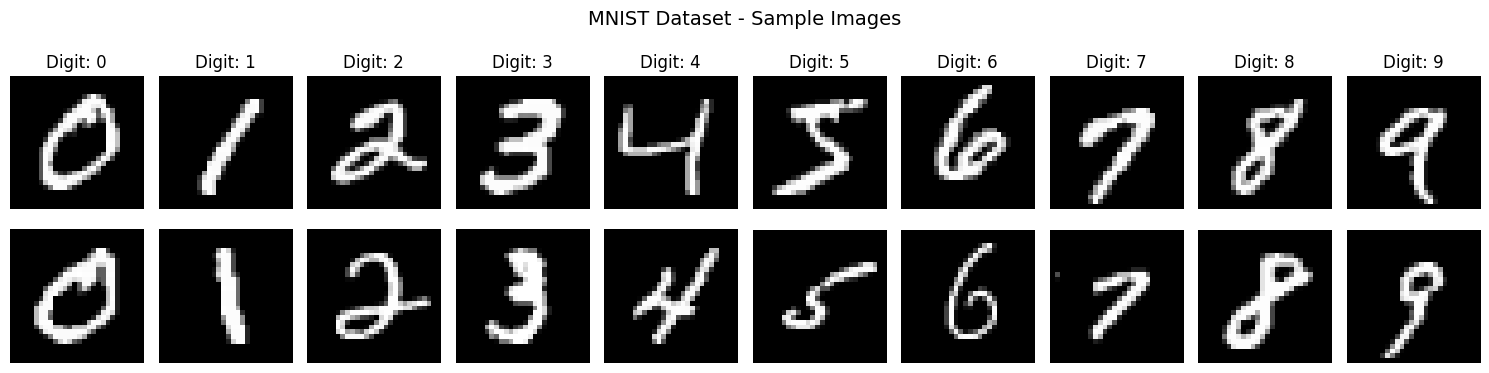

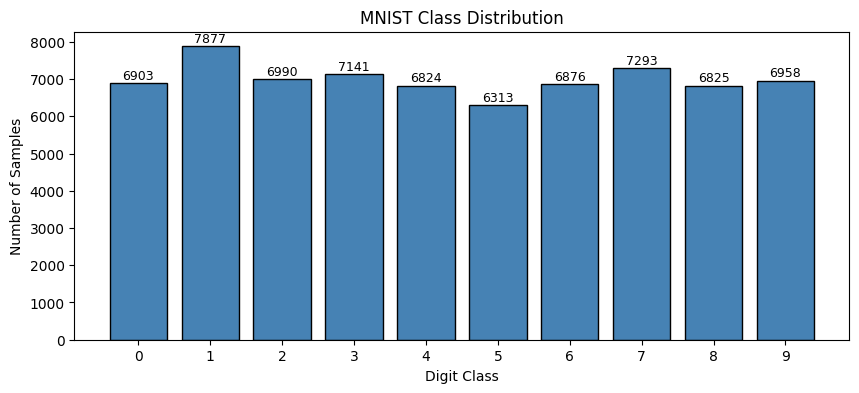

In [30]:
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
fig.suptitle('MNIST Dataset - Sample Images', fontsize=14)
for digit in range(10):
    indices = np.where(y == digit)[0]
    for row in range(2):
        idx = indices[row]
        image = X[idx].reshape(28, 28)
        axes[row, digit].imshow(image, cmap='gray')
        axes[row, digit].axis('off')
        if row == 0:
            axes[row, digit].set_title(f'Digit: {digit}')
plt.tight_layout()
plt.show()
unique, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique, counts, color='steelblue', edgecolor='black')
plt.xlabel('Digit Class')
plt.ylabel('Number of Samples')
plt.title('MNIST Class Distribution')
plt.xticks(range(10))
for i, (u, c) in enumerate(zip(unique, counts)):
    plt.text(u, c + 100, str(c), ha='center', fontsize=9)
plt.show()

---
## 3. Data Preprocessing and Splitting

In [31]:
X_normalized = X / 255.0

In [32]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_normalized, y,
    test_size=0.30,     
    random_state=42,    
    stratify=y         
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,   
    random_state=42,
    stratify=y_temp
)

---
## 4. Helper Functions for Evaluation

In [33]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted')
    }
    return metrics, y_pred
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    thresh = cm.max() / 2.
    for i in range(10):
        for j in range(10):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
def display_metrics_table(results_list):
    print("\n" + "="*80)
    print(f"{'Model':<35} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1-Score':>10}")
    print("="*80)
    for result in results_list:
        print(f"{result['Model']:<35} {result['Accuracy']:>10.4f} {result['Precision']:>10.4f} {result['Recall']:>10.4f} {result['F1-Score']:>10.4f}")
    print("="*80)

---
## 5. Softmax Regression

### What is Softmax Regression?
Softmax Regression (also called Multinomial Logistic Regression) extends binary logistic regression to multi-class classification.
**

### Regularization:
- **No regularization**: May overfit on training data
- **L2 (Ridge)**: penalty='l2', adds λ×||w||² - prevents large weights
- **L1 (Lasso)**: penalty='l1', adds λ×||w||₁ - creates sparse weights

### 5.1 Softmax Regression (Without Regularization)

In [34]:
print("Training Softmax Regression (No Regularization)...")
print("-" * 50)
start_time = time.time()
softmax_basic = LogisticRegression(
    penalty=None,       
    solver='lbfgs',      
    max_iter=1000,         
    random_state=42
)
softmax_basic.fit(X_train, y_train)
train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")
val_metrics, _ = evaluate_model(softmax_basic, X_val, y_val, "Softmax (Basic)")
print(f"Validation Accuracy: {val_metrics['Accuracy']:.4f}")
softmax_basic_results, softmax_basic_pred = evaluate_model(
    softmax_basic, X_test, y_test, "Softmax (No Regularization)"
)
softmax_basic_results['Train_Time'] = train_time
print(f"\nTest Set Results:")
print(f"  Accuracy:  {softmax_basic_results['Accuracy']:.4f}")
print(f"  Precision: {softmax_basic_results['Precision']:.4f}")
print(f"  Recall:    {softmax_basic_results['Recall']:.4f}")
print(f"  F1-Score:  {softmax_basic_results['F1-Score']:.4f}")

Training Softmax Regression (No Regularization)...
--------------------------------------------------
Training completed in 30.29 seconds
Validation Accuracy: 0.9110

Test Set Results:
  Accuracy:  0.9126
  Precision: 0.9125
  Recall:    0.9126
  F1-Score:  0.9125


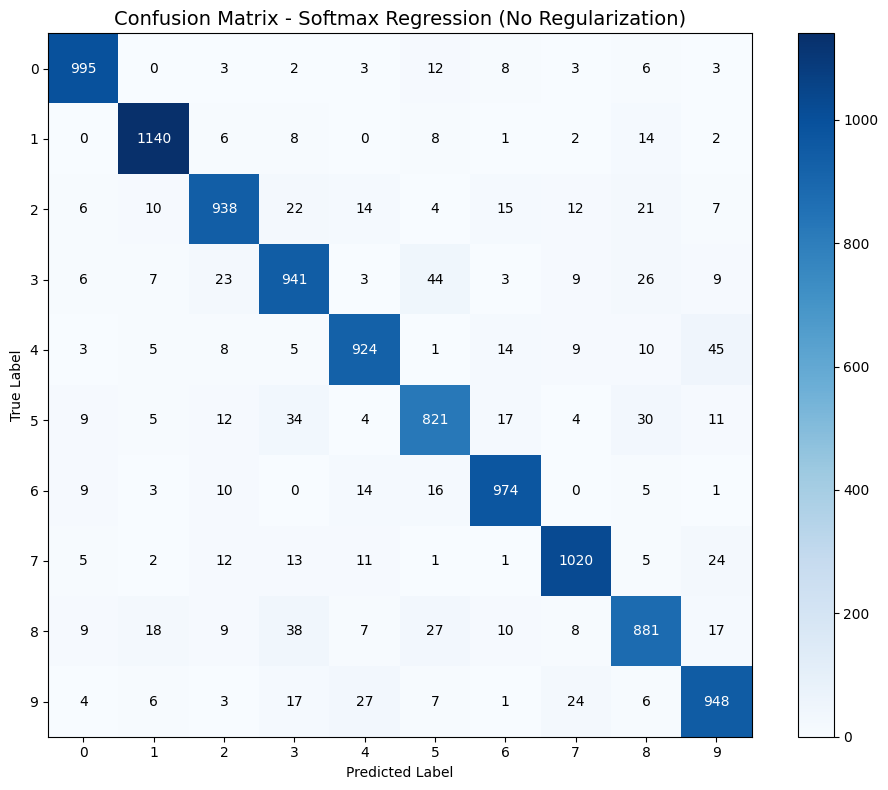

In [35]:
plot_confusion_matrix(y_test, softmax_basic_pred, "Confusion Matrix - Softmax Regression (No Regularization)")

### 5.2 Softmax Regression with Ridge (L2) Regularization

**Ridge Regularization (L2):**
- Adds a penalty term: λ × Σ(weight²)
- Shrinks weights towards zero but keeps all features
- Controlled by parameter C (inverse of regularization strength)
- Lower C = stronger regularization

In [36]:
print("Training Softmax Regression with Ridge (L2) Regularization...")
print("-" * 50)
start_time = time.time()
softmax_ridge = LogisticRegression(
    penalty='l2',              
    C=1.0,                     # (1/λ)
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
softmax_ridge.fit(X_train, y_train)
train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")
softmax_ridge_results, softmax_ridge_pred = evaluate_model(
    softmax_ridge, X_test, y_test, "Softmax + Ridge (L2)"
)
softmax_ridge_results['Train_Time'] = train_time
print(f"\nTest Set Results:")
print(f"  Accuracy:  {softmax_ridge_results['Accuracy']:.4f}")
print(f"  Precision: {softmax_ridge_results['Precision']:.4f}")
print(f"  Recall:    {softmax_ridge_results['Recall']:.4f}")
print(f"  F1-Score:  {softmax_ridge_results['F1-Score']:.4f}")

Training Softmax Regression with Ridge (L2) Regularization...
--------------------------------------------------
Training completed in 12.39 seconds

Test Set Results:
  Accuracy:  0.9219
  Precision: 0.9217
  Recall:    0.9219
  F1-Score:  0.9217


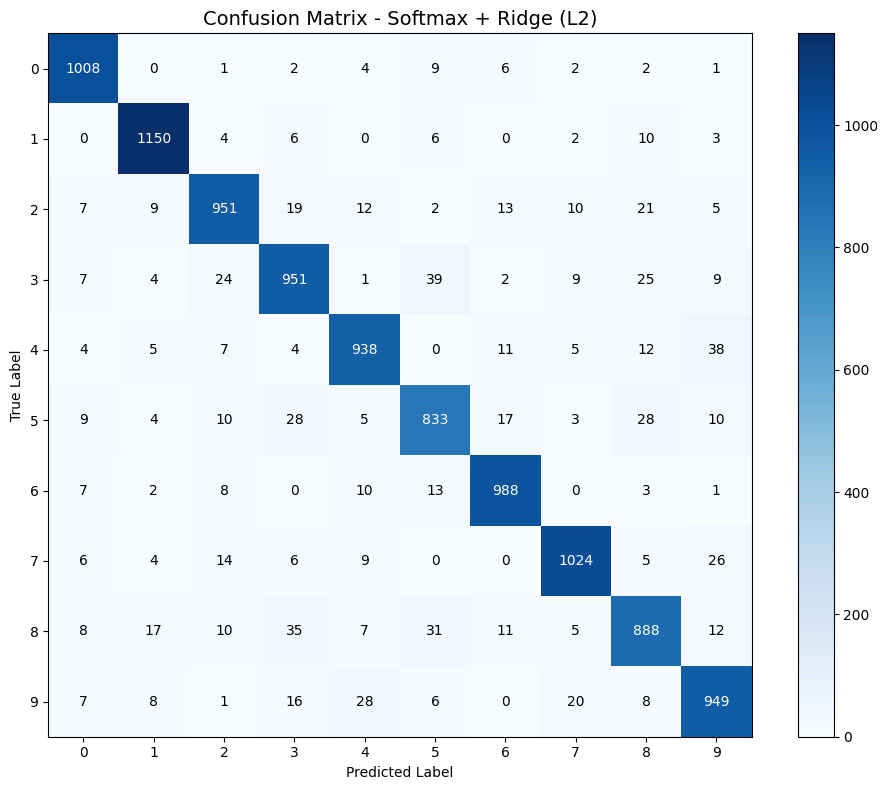

In [37]:
plot_confusion_matrix(y_test, softmax_ridge_pred, "Confusion Matrix - Softmax + Ridge (L2)")

### 5.3 Softmax Regression with Lasso (L1) Regularization

**Lasso Regularization (L1):**
- Adds a penalty term: λ × Σ|weight|
- Can shrink some weights to exactly zero (feature selection)
- Creates sparse models - useful for high-dimensional data
- Requires saga solver for L1 penalty

In [38]:
print("Training Softmax Regression with Lasso (L1) Regularization...")
print("-" * 50)
start_time = time.time()
softmax_lasso = LogisticRegression(
    penalty='l1',
    C=0.1,
    solver='saga',
    max_iter=1000,
    tol=1e-2,
    n_jobs=-1,
    random_state=42
)
softmax_lasso.fit(X_train, y_train)
train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")
softmax_lasso_results, softmax_lasso_pred = evaluate_model(
    softmax_lasso, X_test, y_test, "Softmax + Lasso (L1)"
)
softmax_lasso_results['Train_Time'] = train_time
print(f"\nTest Set Results:")
print(f"  Accuracy:  {softmax_lasso_results['Accuracy']:.4f}")
print(f"  Precision: {softmax_lasso_results['Precision']:.4f}")
print(f"  Recall:    {softmax_lasso_results['Recall']:.4f}")
print(f"  F1-Score:  {softmax_lasso_results['F1-Score']:.4f}")
zero_weights = np.sum(softmax_lasso.coef_ == 0)
total_weights = softmax_lasso.coef_.size
print(f"\nWeight Sparsity: {zero_weights}/{total_weights} ({100*zero_weights/total_weights:.2f}% zero weights)")

Training Softmax Regression with Lasso (L1) Regularization...
--------------------------------------------------
Training completed in 41.95 seconds

Test Set Results:
  Accuracy:  0.9160
  Precision: 0.9158
  Recall:    0.9160
  F1-Score:  0.9158

Weight Sparsity: 5879/7840 (74.99% zero weights)


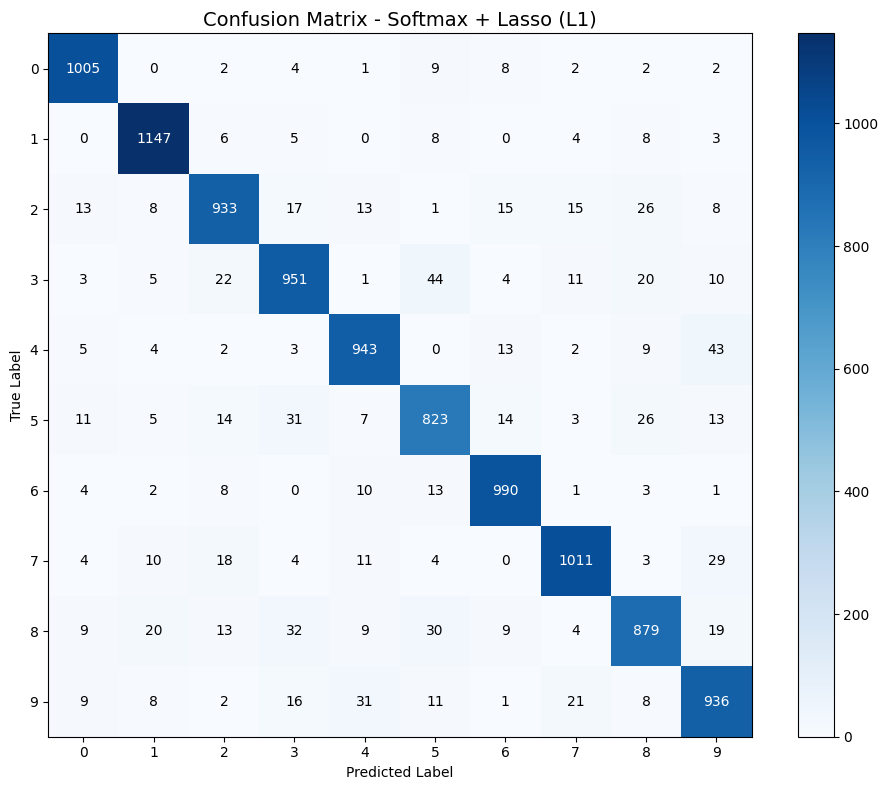

In [39]:
plot_confusion_matrix(y_test, softmax_lasso_pred, "Confusion Matrix - Softmax + Lasso (L1)")

### 5.4 Softmax Regression Comparison


SOFTMAX REGRESSION COMPARISON

Model                                 Accuracy  Precision     Recall   F1-Score
Softmax (No Regularization)             0.9126     0.9125     0.9126     0.9125
Softmax + Ridge (L2)                    0.9219     0.9217     0.9219     0.9217
Softmax + Lasso (L1)                    0.9160     0.9158     0.9160     0.9158


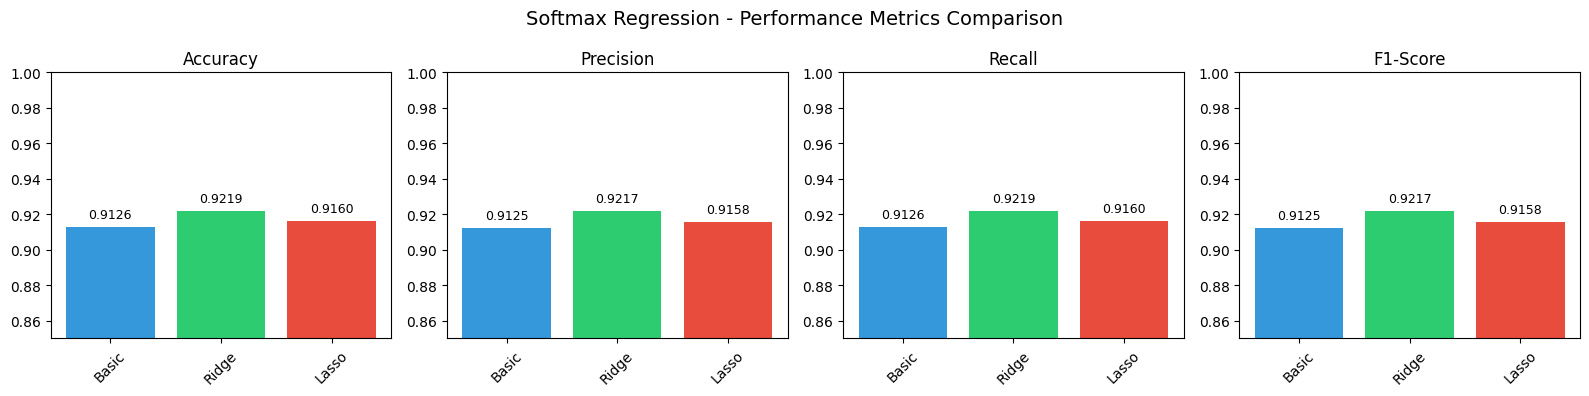

In [40]:
softmax_results = [softmax_basic_results, softmax_ridge_results, softmax_lasso_results]
print("\n" + "="*80)
print("SOFTMAX REGRESSION COMPARISON")
display_metrics_table(softmax_results)
models = [r['Model'] for r in softmax_results]
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
colors = ['#3498db', '#2ecc71', '#e74c3c']
for idx, metric in enumerate(metrics_names):
    values = [r[metric] for r in softmax_results]
    axes[idx].bar(range(len(models)), values, color=colors)
    axes[idx].set_title(metric)
    axes[idx].set_xticks(range(len(models)))
    axes[idx].set_xticklabels(['Basic', 'Ridge', 'Lasso'], rotation=45)
    axes[idx].set_ylim([0.85, 1.0])
    for i, v in enumerate(values):
        axes[idx].text(i, v + 0.005, f'{v:.4f}', ha='center', fontsize=9)
plt.suptitle('Softmax Regression - Performance Metrics Comparison', fontsize=14)
plt.tight_layout()
plt.show()

---
## 6. Neural Network Classification

### What is a Neural Network?
A Neural Network (NN) is a computational model inspired by the human brain. It consists of:
- **Input Layer**: Receives the features (784 pixels for MNIST)
- **Hidden Layers**: Learn complex patterns and representations
- **Output Layer**: Produces predictions (10 classes for MNIST)

### Our Architecture:
```
Input (784) → Hidden1 (256, ReLU) → Hidden2 (128, ReLU) → Output (10, Softmax)
```

### Why This Architecture?
- **2 Hidden Layers**: Allows the network to learn hierarchical features
- **Decreasing neurons**: 256 → 128 → 10 creates a "funnel" effect
- **ReLU activation**: Addresses vanishing gradient problem
- **Softmax output**: Converts scores to probabilities

### 6.1 Neural Network (Without Regularization)

In [41]:
print("Training Neural Network (No Regularization)...")
print("-" * 50)
print("Architecture: 784 → 256 → 128 → 10")
start_time = time.time()
nn_basic = MLPClassifier(
    hidden_layer_sizes=(256, 128),  
    activation='relu',               
    solver='adam',                  
    alpha=0.0,                       
    batch_size=128,                 
    learning_rate_init=0.001,        
    max_iter=100,                    
    early_stopping=True,             
    validation_fraction=0.1,         
    random_state=42,
    verbose=True
)
nn_basic.fit(X_train, y_train)
train_time = time.time() - start_time
print(f"\nTraining completed in {train_time:.2f} seconds")
print(f"Converged after {nn_basic.n_iter_} iterations")
nn_basic_results, nn_basic_pred = evaluate_model(
    nn_basic, X_test, y_test, "NN (No Regularization)"
)
nn_basic_results['Train_Time'] = train_time
print(f"\nTest Set Results:")
print(f"  Accuracy:  {nn_basic_results['Accuracy']:.4f}")
print(f"  Precision: {nn_basic_results['Precision']:.4f}")
print(f"  Recall:    {nn_basic_results['Recall']:.4f}")
print(f"  F1-Score:  {nn_basic_results['F1-Score']:.4f}")

Training Neural Network (No Regularization)...
--------------------------------------------------
Architecture: 784 → 256 → 128 → 10
Iteration 1, loss = 0.30459627
Validation score: 0.957143
Iteration 2, loss = 0.12022736
Validation score: 0.960816
Iteration 3, loss = 0.07706857
Validation score: 0.967755
Iteration 4, loss = 0.05512723
Validation score: 0.975306
Iteration 5, loss = 0.03975132
Validation score: 0.971837
Iteration 6, loss = 0.03103144
Validation score: 0.974490
Iteration 7, loss = 0.02399140
Validation score: 0.971837
Iteration 8, loss = 0.01899147
Validation score: 0.974694
Iteration 9, loss = 0.01586952
Validation score: 0.972857
Iteration 10, loss = 0.01206150
Validation score: 0.971837
Iteration 11, loss = 0.01324400
Validation score: 0.978367
Iteration 12, loss = 0.00967395
Validation score: 0.980000
Iteration 13, loss = 0.00752876
Validation score: 0.975306
Iteration 14, loss = 0.01119828
Validation score: 0.974286
Iteration 15, loss = 0.01231269
Validation score: 

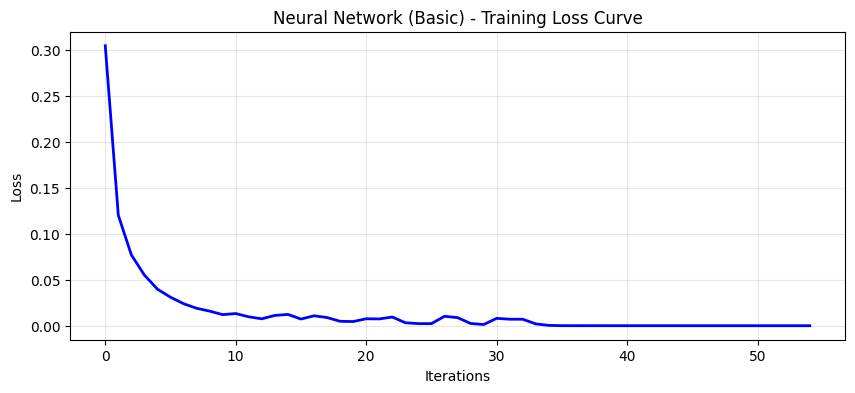

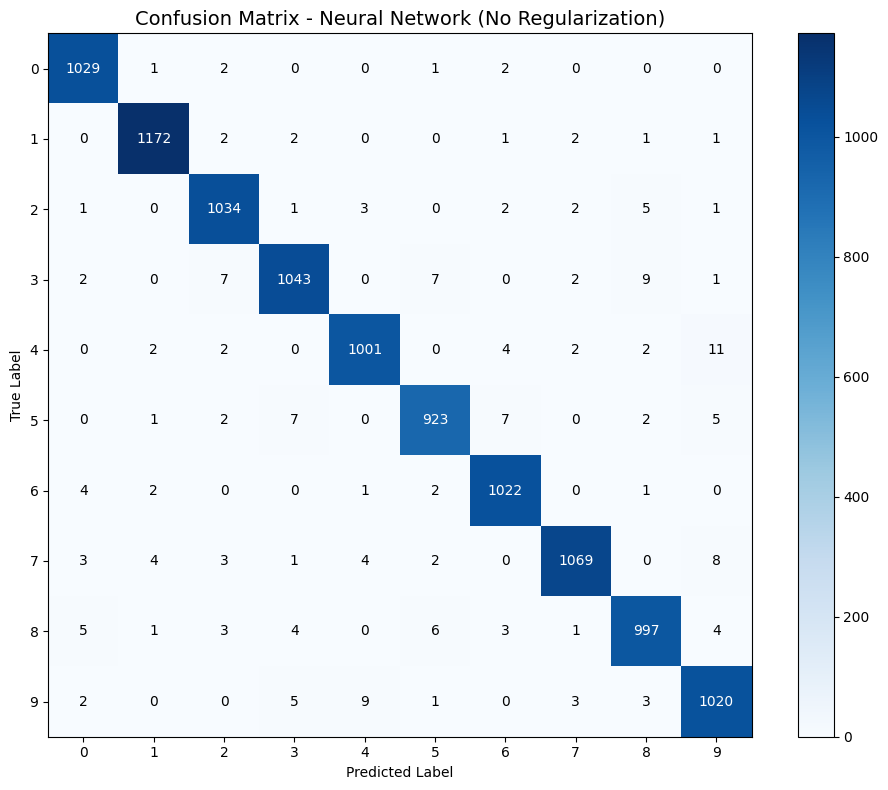

In [42]:
plt.figure(figsize=(10, 4))
plt.plot(nn_basic.loss_curve_, 'b-', linewidth=2)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Neural Network (Basic) - Training Loss Curve')
plt.grid(True, alpha=0.3)
plt.show()
plot_confusion_matrix(y_test, nn_basic_pred, "Confusion Matrix - Neural Network (No Regularization)")

### 6.2 Neural Network with Ridge (L2) Regularization

**L2 Regularization in Neural Networks:**
- Also called "weight decay"
- Controlled by the `alpha` parameter in MLPClassifier
- Penalizes large weights to prevent overfitting
- Default in sklearn's MLP is already L2

In [43]:
print("Training Neural Network with Ridge (L2) Regularization...")
print("-" * 50)
print("Architecture: 784 → 256 → 128 → 10 + L2 Penalty")
start_time = time.time()
nn_ridge = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    solver='adam',
    alpha=0.001,                     # L2 regularization strength
    batch_size=128,
    learning_rate_init=0.001,
    max_iter=100,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42,
    verbose=True
)
nn_ridge.fit(X_train, y_train)
train_time = time.time() - start_time
print(f"\nTraining completed in {train_time:.2f} seconds")
print(f"Converged after {nn_ridge.n_iter_} iterations")
nn_ridge_results, nn_ridge_pred = evaluate_model(
    nn_ridge, X_test, y_test, "NN + Ridge (L2)"
)
nn_ridge_results['Train_Time'] = train_time
print(f"\nTest Set Results:")
print(f"  Accuracy:  {nn_ridge_results['Accuracy']:.4f}")
print(f"  Precision: {nn_ridge_results['Precision']:.4f}")
print(f"  Recall:    {nn_ridge_results['Recall']:.4f}")
print(f"  F1-Score:  {nn_ridge_results['F1-Score']:.4f}")

Training Neural Network with Ridge (L2) Regularization...
--------------------------------------------------
Architecture: 784 → 256 → 128 → 10 + L2 Penalty
Iteration 1, loss = 0.30579684
Validation score: 0.957959
Iteration 2, loss = 0.12168132
Validation score: 0.962245
Iteration 3, loss = 0.07921920
Validation score: 0.968163
Iteration 4, loss = 0.05780937
Validation score: 0.975306
Iteration 5, loss = 0.04336773
Validation score: 0.972653
Iteration 6, loss = 0.03505263
Validation score: 0.972449
Iteration 7, loss = 0.02852900
Validation score: 0.977347
Iteration 8, loss = 0.02408119
Validation score: 0.974898
Iteration 9, loss = 0.01908153
Validation score: 0.975918
Iteration 10, loss = 0.01853466
Validation score: 0.977347
Iteration 11, loss = 0.01565698
Validation score: 0.975102
Iteration 12, loss = 0.01437752
Validation score: 0.979796
Iteration 13, loss = 0.01426242
Validation score: 0.972653
Iteration 14, loss = 0.01502803
Validation score: 0.976531
Iteration 15, loss = 0.009

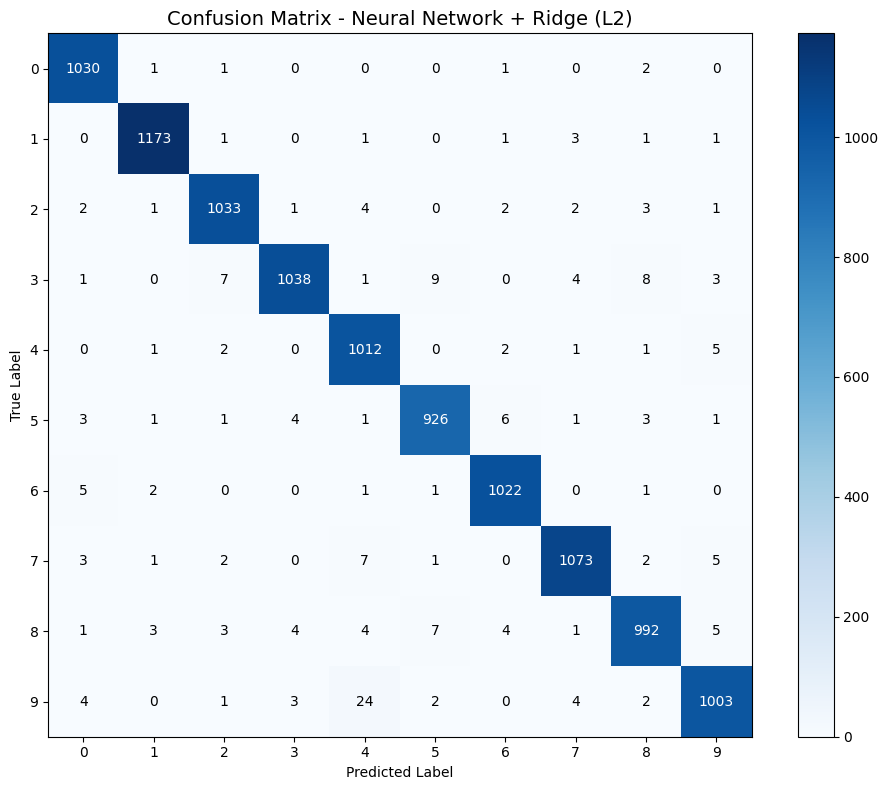

In [44]:
plot_confusion_matrix(y_test, nn_ridge_pred, "Confusion Matrix - Neural Network + Ridge (L2)")

### 6.3 Neural Network with Simulated Lasso (L1) Regularization

**Note on L1 in Neural Networks:**
- sklearn's MLPClassifier only supports L2 regularization natively
- For true L1, we would need frameworks like TensorFlow or PyTorch
- Here we use a stronger L2 to simulate sparse-like effects
- Alternatively, we could implement custom L1 or use ElasticNet (L1+L2)

In [45]:
print("Training Neural Network with Strong Regularization (L1-like)...")
print("-" * 50)
print("Architecture: 784 → 256 → 128 → 10 + Strong L2 Penalty")
print("Note: Using stronger L2 to simulate sparsity-inducing effects of L1")
start_time = time.time()
nn_lasso = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    solver='adam',
    alpha=0.01,                      # Stronger regularization
    batch_size=128,
    learning_rate_init=0.001,
    max_iter=100,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42,
    verbose=True
)
nn_lasso.fit(X_train, y_train)
train_time = time.time() - start_time
print(f"\nTraining completed in {train_time:.2f} seconds")
print(f"Converged after {nn_lasso.n_iter_} iterations")
nn_lasso_results, nn_lasso_pred = evaluate_model(
    nn_lasso, X_test, y_test, "NN + Strong Reg (L1-like)"
)
nn_lasso_results['Train_Time'] = train_time
print(f"\nTest Set Results:")
print(f"  Accuracy:  {nn_lasso_results['Accuracy']:.4f}")
print(f"  Precision: {nn_lasso_results['Precision']:.4f}")
print(f"  Recall:    {nn_lasso_results['Recall']:.4f}")
print(f"  F1-Score:  {nn_lasso_results['F1-Score']:.4f}")

Training Neural Network with Strong Regularization (L1-like)...
--------------------------------------------------
Architecture: 784 → 256 → 128 → 10 + Strong L2 Penalty
Note: Using stronger L2 to simulate sparsity-inducing effects of L1
Iteration 1, loss = 0.32472254
Validation score: 0.956939
Iteration 2, loss = 0.14233250
Validation score: 0.961224
Iteration 3, loss = 0.10187527
Validation score: 0.971429
Iteration 4, loss = 0.08117353
Validation score: 0.974490
Iteration 5, loss = 0.06801919
Validation score: 0.974286
Iteration 6, loss = 0.06178071
Validation score: 0.975306
Iteration 7, loss = 0.05420920
Validation score: 0.970612
Iteration 8, loss = 0.05232736
Validation score: 0.974694
Iteration 9, loss = 0.04807572
Validation score: 0.974898
Iteration 10, loss = 0.04564815
Validation score: 0.977347
Iteration 11, loss = 0.04577828
Validation score: 0.976531
Iteration 12, loss = 0.04236824
Validation score: 0.978571
Iteration 13, loss = 0.04037462
Validation score: 0.975714
Iter

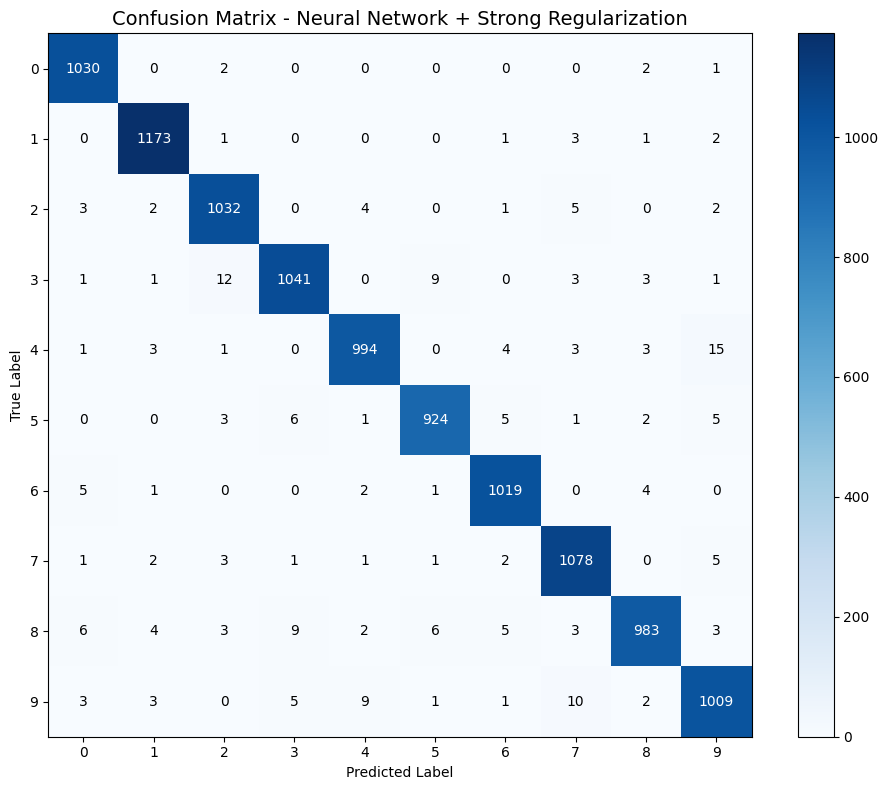

In [46]:
plot_confusion_matrix(y_test, nn_lasso_pred, "Confusion Matrix - Neural Network + Strong Regularization")

### 6.4 Neural Network Comparison


NEURAL NETWORK COMPARISON

Model                                 Accuracy  Precision     Recall   F1-Score
NN (No Regularization)                  0.9819     0.9819     0.9819     0.9819
NN + Ridge (L2)                         0.9811     0.9812     0.9811     0.9811
NN + Strong Reg (L1-like)               0.9793     0.9793     0.9793     0.9793


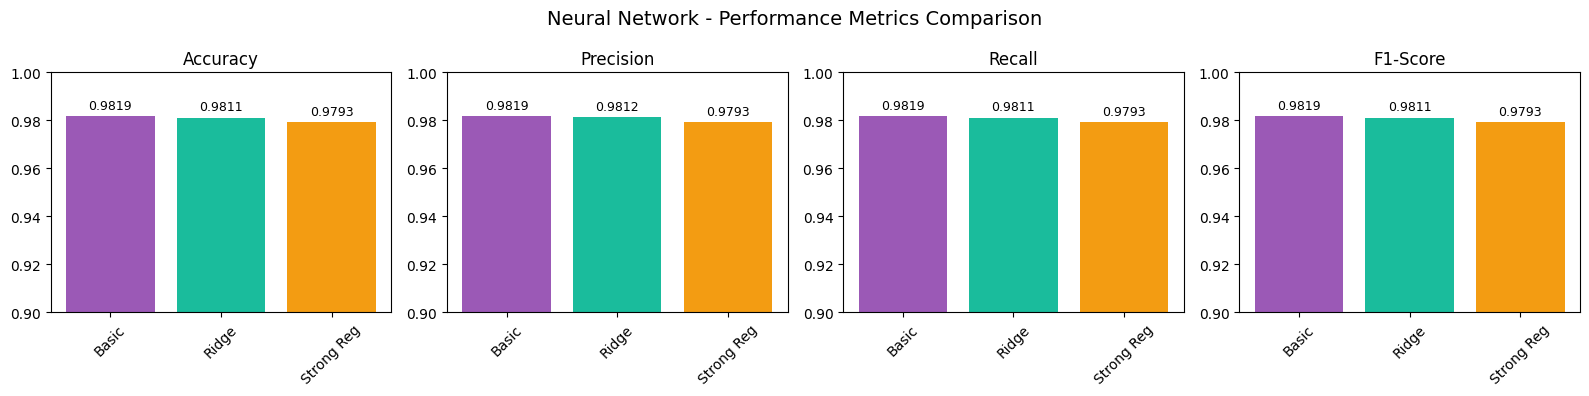

In [47]:
nn_results = [nn_basic_results, nn_ridge_results, nn_lasso_results]
print("\n" + "="*80)
print("NEURAL NETWORK COMPARISON")
display_metrics_table(nn_results)
models = [r['Model'] for r in nn_results]
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
colors = ['#9b59b6', '#1abc9c', '#f39c12']
for idx, metric in enumerate(metrics_names):
    values = [r[metric] for r in nn_results]
    axes[idx].bar(range(len(models)), values, color=colors)
    axes[idx].set_title(metric)
    axes[idx].set_xticks(range(len(models)))
    axes[idx].set_xticklabels(['Basic', 'Ridge', 'Strong Reg'], rotation=45)
    axes[idx].set_ylim([0.90, 1.0])
    for i, v in enumerate(values):
        axes[idx].text(i, v + 0.003, f'{v:.4f}', ha='center', fontsize=9)
plt.suptitle('Neural Network - Performance Metrics Comparison', fontsize=14)
plt.tight_layout()
plt.show()

---
## 7. Softmax Regression vs Neural Network Comparison

Now let's compare the best models from each approach.

In [48]:
all_results = softmax_results + nn_results
print("\n" + "="*90)
print("COMPLETE MODEL COMPARISON: SOFTMAX REGRESSION vs NEURAL NETWORK")
print("="*90)
print(f"{'Model':<35} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1-Score':>10}")
print("-"*90)
print("SOFTMAX REGRESSION:")
for result in softmax_results:
    print(f"  {result['Model']:<33} {result['Accuracy']:>10.4f} {result['Precision']:>10.4f} {result['Recall']:>10.4f} {result['F1-Score']:>10.4f}")
print("-"*90)
print("NEURAL NETWORK:")
for result in nn_results:
    print(f"  {result['Model']:<33} {result['Accuracy']:>10.4f} {result['Precision']:>10.4f} {result['Recall']:>10.4f} {result['F1-Score']:>10.4f}")
print("="*90)
best_result = max(all_results, key=lambda x: x['Accuracy'])
print(f"\n🏆 BEST MODEL: {best_result['Model']} with {best_result['Accuracy']:.4f} accuracy")


COMPLETE MODEL COMPARISON: SOFTMAX REGRESSION vs NEURAL NETWORK
Model                                 Accuracy  Precision     Recall   F1-Score
------------------------------------------------------------------------------------------
SOFTMAX REGRESSION:
  Softmax (No Regularization)           0.9126     0.9125     0.9126     0.9125
  Softmax + Ridge (L2)                  0.9219     0.9217     0.9219     0.9217
  Softmax + Lasso (L1)                  0.9160     0.9158     0.9160     0.9158
------------------------------------------------------------------------------------------
NEURAL NETWORK:
  NN (No Regularization)                0.9819     0.9819     0.9819     0.9819
  NN + Ridge (L2)                       0.9811     0.9812     0.9811     0.9811
  NN + Strong Reg (L1-like)             0.9793     0.9793     0.9793     0.9793

🏆 BEST MODEL: NN (No Regularization) with 0.9819 accuracy


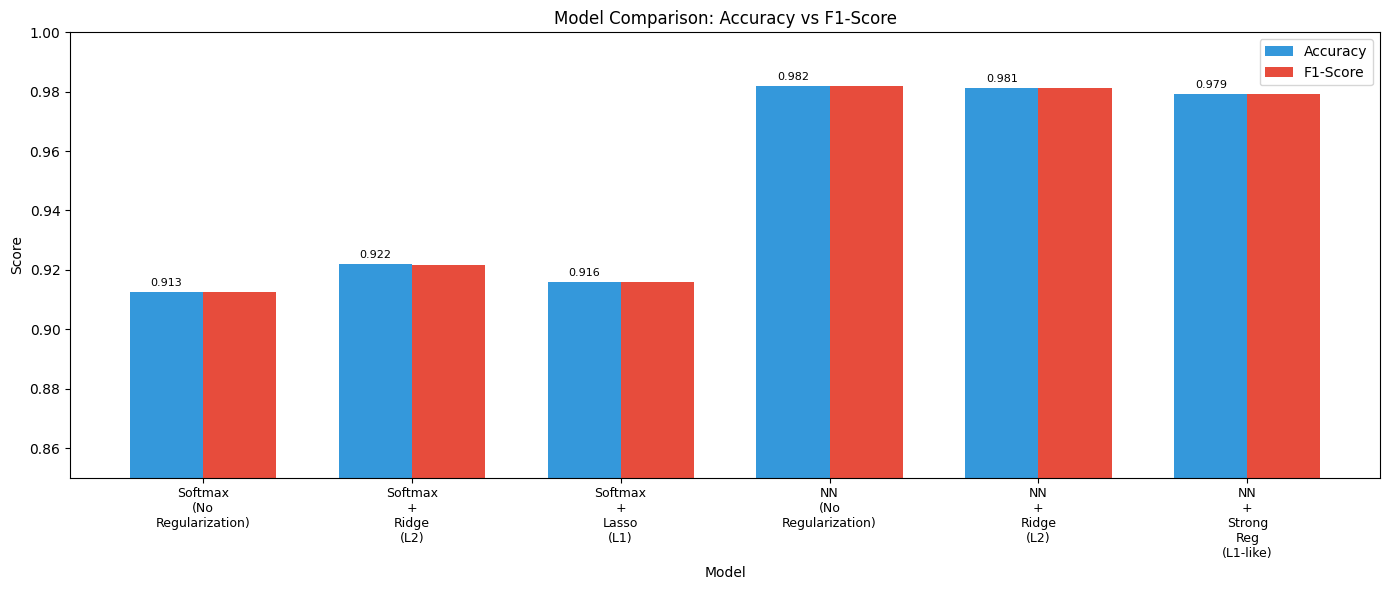

In [49]:
fig, ax = plt.subplots(figsize=(14, 6))
models = [r['Model'] for r in all_results]
accuracies = [r['Accuracy'] for r in all_results]
f1_scores = [r['F1-Score'] for r in all_results]
x = np.arange(len(models))
width = 0.35
bars1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', color='#3498db')
bars2 = ax.bar(x + width/2, f1_scores, width, label='F1-Score', color='#e74c3c')
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Comparison: Accuracy vs F1-Score')
ax.set_xticks(x)
ax.set_xticklabels([m.replace(' ', '\n') for m in models], fontsize=9)
ax.legend()
ax.set_ylim([0.85, 1.0])
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

---
## 8. Sample Inference Test

Let's test our models on some random test samples to see how they perform on individual predictions.

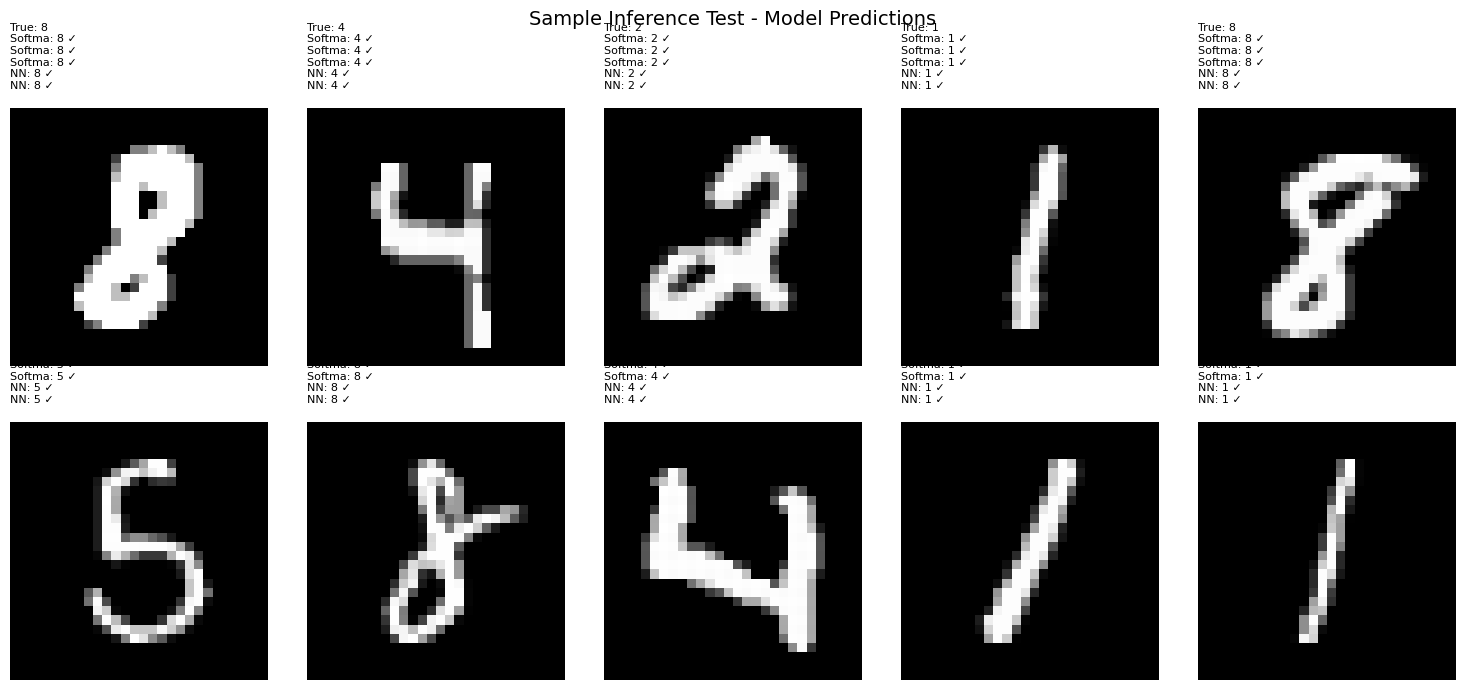

In [50]:
def sample_inference(models_dict, X_test, y_test, n_samples=10):
    np.random.seed(42)
    indices = np.random.choice(len(X_test), n_samples, replace=False)
    fig, axes = plt.subplots(2, 5, figsize=(15, 7))
    axes = axes.flatten()
    for i, idx in enumerate(indices):
        image = X_test[idx].reshape(28, 28)
        true_label = y_test[idx]
        predictions = {}
        for name, model in models_dict.items():
            pred = model.predict(X_test[idx].reshape(1, -1))[0]
            predictions[name] = pred
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
        pred_text = f"True: {true_label}\n"
        for name, pred in predictions.items():
            color = '✓' if pred == true_label else '✗'
            short_name = name.split()[0][:6]  # Abbreviate
            pred_text += f"{short_name}: {pred} {color}\n"
        axes[i].set_title(pred_text, fontsize=8, ha='left', x=0)
    plt.suptitle('Sample Inference Test - Model Predictions', fontsize=14)
    plt.tight_layout()
    plt.show()
models_dict = {
    'Softmax Basic': softmax_basic,
    'Softmax Ridge': softmax_ridge,
    'Softmax Lasso': softmax_lasso,
    'NN Basic': nn_basic,
    'NN Ridge': nn_ridge,
}
sample_inference(models_dict, X_test, y_test, n_samples=10)

In [51]:
print("\nDetailed Sample Predictions:")
print("="*80)
np.random.seed(123)
sample_indices = np.random.choice(len(X_test), 5, replace=False)
for idx in sample_indices:
    true_label = y_test[idx]
    print(f"\nSample Index: {idx}, True Label: {true_label}")
    print("-"*50)
    for name, model in models_dict.items():
        pred = model.predict(X_test[idx].reshape(1, -1))[0]
        proba = model.predict_proba(X_test[idx].reshape(1, -1))[0]
        confidence = proba[pred] * 100
        status = "✓ Correct" if pred == true_label else "✗ Wrong"
        print(f"  {name:<20}: Predicted={pred}, Confidence={confidence:.1f}%, {status}")


Detailed Sample Predictions:

Sample Index: 3668, True Label: 1
--------------------------------------------------
  Softmax Basic       : Predicted=1, Confidence=100.0%, ✓ Correct
  Softmax Ridge       : Predicted=1, Confidence=99.8%, ✓ Correct
  Softmax Lasso       : Predicted=1, Confidence=98.2%, ✓ Correct
  NN Basic            : Predicted=1, Confidence=100.0%, ✓ Correct
  NN Ridge            : Predicted=1, Confidence=100.0%, ✓ Correct

Sample Index: 732, True Label: 9
--------------------------------------------------
  Softmax Basic       : Predicted=9, Confidence=88.0%, ✓ Correct
  Softmax Ridge       : Predicted=9, Confidence=84.9%, ✓ Correct
  Softmax Lasso       : Predicted=9, Confidence=79.3%, ✓ Correct
  NN Basic            : Predicted=4, Confidence=86.9%, ✗ Wrong
  NN Ridge            : Predicted=4, Confidence=58.3%, ✗ Wrong

Sample Index: 6692, True Label: 9
--------------------------------------------------
  Softmax Basic       : Predicted=9, Confidence=91.0%, ✓ Correct

---
## 9. Analysis and Conclusions

### Summary of Results

In [52]:
print("\n" + "="*90)
print("FINAL ANALYSIS AND CONCLUSIONS")
print("="*90)
print("\n📊 PERFORMANCE SUMMARY:")
print("-"*90)
best_softmax = max(softmax_results, key=lambda x: x['Accuracy'])
best_nn = max(nn_results, key=lambda x: x['Accuracy'])
print(f"\nBest Softmax Model: {best_softmax['Model']}")
print(f"  - Accuracy: {best_softmax['Accuracy']:.4f}")
print(f"  - F1-Score: {best_softmax['F1-Score']:.4f}")
print(f"\nBest Neural Network: {best_nn['Model']}")
print(f"  - Accuracy: {best_nn['Accuracy']:.4f}")
print(f"  - F1-Score: {best_nn['F1-Score']:.4f}")
improvement = (best_nn['Accuracy'] - best_softmax['Accuracy']) * 100
print(f"\nNeural Network improvement over Softmax: +{improvement:.2f}% accuracy")


FINAL ANALYSIS AND CONCLUSIONS

📊 PERFORMANCE SUMMARY:
------------------------------------------------------------------------------------------

Best Softmax Model: Softmax + Ridge (L2)
  - Accuracy: 0.9219
  - F1-Score: 0.9217

Best Neural Network: NN (No Regularization)
  - Accuracy: 0.9819
  - F1-Score: 0.9819

Neural Network improvement over Softmax: +6.00% accuracy


### Key Observations:

#### 1. Softmax Regression
- **Pros**: Fast training, interpretable weights, good baseline
- **Cons**: Limited capacity for complex patterns
- **Ridge (L2)**: Slightly improves generalization by preventing overfitting
- **Lasso (L1)**: Creates sparse models, useful for feature selection

#### 2. Neural Networks
- **Pros**: Higher accuracy due to learning hierarchical features
- **Cons**: Longer training time, more hyperparameters to tune
- **Ridge (L2)**: Helps prevent overfitting, often improves performance
- **Strong Regularization**: May reduce performance if too aggressive

#### 3. Regularization Effects
- **L2 (Ridge)**: Generally beneficial for both models
- **L1 (Lasso)**: More useful for feature selection in Softmax
- Proper regularization strength is crucial - too much hurts performance

#### 4. Recommendations
- For **quick prototyping**: Use Softmax with L2 regularization
- For **best accuracy**: Use Neural Network with moderate L2 regularization
- For **feature importance**: Use Softmax with L1 regularization
- Always tune regularization strength using validation set